# Proyek Akhir: Menyelesaikan Permasalahan Perusahaan Jaya Student Performance

- Nama: Daniel Siahaan
- Email: lisnarda.siregar1212@gmail.com
- Id Dicoding: niels11

## Persiapan

### Menyiapkan library yang dibutuhkan
#### 1. Import Library
   Pada tahap ini, kita mengimpor seluruh pustaka yang dibutuhkan dalam pipeline data science, mulai dari eksplorasi data, preprocessing, modeling, evaluasi, visualisasi, hingga penyimpanan model. Library yang digunakan termasuk scikit-learn, XGBoost, CatBoost, seaborn, matplotlib, SHAP untuk interpretasi model, dan imbalanced-learn untuk menangani ketidakseimbangan kelas.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import shap
import pickle
import warnings
warnings.filterwarnings("ignore")

### Menyiapkan data yang akan digunakan

## Data Understanding


Pada tahap ini dilakukan:
- Pengecekan missing value
- Pengecekan data duplikat
- Pemeriksaan tipe data dan konsistensi format (misal tanggal)
- Evaluasi relevansi fitur dan potensi bias
- (Opsional) Deteksi dan visualisasi outlier pada fitur numerik utama

Langkah ini penting untuk memastikan data yang digunakan bersih, konsisten, dan siap untuk proses modeling.

**2. Load Dataset**

Dataset yang digunakan berisi informasi akademik dan demografis mahasiswa, dengan target klasifikasi `Status` yang menunjukkan apakah mahasiswa tersebut "Dropout", "Graduate", atau masih "Enrolled". Dataset ini dimuat ke dalam DataFrame dan ditampilkan beberapa baris awal untuk memahami struktur dan tipe data yang tersedia.


In [2]:
# Load dataset
file_path = './data.csv'
# df = pd.read_csv(file_path, sep=';', encoding='windows-1252')
df = pd.read_csv('data.csv', sep=';', encoding='utf-8-sig')

# 1. Cek dimensi dan nama kolom
print(df.shape)
print(df.columns.tolist())
print(df.head())


(4424, 37)
['Marital_status', 'Application_mode', 'Application_order', 'Course', 'Daytime_evening_attendance', 'Previous_qualification', 'Previous_qualification_grade', 'Nacionality', 'Mothers_qualification', 'Fathers_qualification', 'Mothers_occupation', 'Fathers_occupation', 'Admission_grade', 'Displaced', 'Educational_special_needs', 'Debtor', 'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder', 'Age_at_enrollment', 'International', 'Curricular_units_1st_sem_credited', 'Curricular_units_1st_sem_enrolled', 'Curricular_units_1st_sem_evaluations', 'Curricular_units_1st_sem_approved', 'Curricular_units_1st_sem_grade', 'Curricular_units_1st_sem_without_evaluations', 'Curricular_units_2nd_sem_credited', 'Curricular_units_2nd_sem_enrolled', 'Curricular_units_2nd_sem_evaluations', 'Curricular_units_2nd_sem_approved', 'Curricular_units_2nd_sem_grade', 'Curricular_units_2nd_sem_without_evaluations', 'Unemployment_rate', 'Inflation_rate', 'GDP', 'Status']
   Marital_status  Application_m

In [3]:
# 2. Cek missing value
print("Jumlah missing value per kolom:")
print(df.isnull().sum())

Jumlah missing value per kolom:
Marital_status                                  0
Application_mode                                0
Application_order                               0
Course                                          0
Daytime_evening_attendance                      0
Previous_qualification                          0
Previous_qualification_grade                    0
Nacionality                                     0
Mothers_qualification                           0
Fathers_qualification                           0
Mothers_occupation                              0
Fathers_occupation                              0
Admission_grade                                 0
Displaced                                       0
Educational_special_needs                       0
Debtor                                          0
Tuition_fees_up_to_date                         0
Gender                                          0
Scholarship_holder                              0
Age_at_enrollment 

In [ ]:
# 3. Cek data duplikat
duplicate_count = df.duplicated().sum()
print(f"Jumlah data duplikat: {duplicate_count}")

# 4. Cek tipe data setiap kolom
print("Tipe data setiap kolom:")
print(df.dtypes)

Jumlah data duplikat: 0
Tipe data setiap kolom:
Marital_status                                    int64
Application_mode                                  int64
Application_order                                 int64
Course                                            int64
Daytime_evening_attendance                        int64
Previous_qualification                            int64
Previous_qualification_grade                    float64
Nacionality                                       int64
Mothers_qualification                             int64
Fathers_qualification                             int64
Mothers_occupation                                int64
Fathers_occupation                                int64
Admission_grade                                 float64
Displaced                                         int64
Educational_special_needs                         int64
Debtor                                            int64
Tuition_fees_up_to_date                           int64


In [5]:
# 5. Pastikan parsing kolom Daytime_evening_attendance sudah benar (harusnya 0/1, bukan datetime)
# Jika kolom ini sudah bertipe int (0/1), langkah ini bisa dilewati
df['Daytime_evening_attendance'] = pd.to_numeric(df['Daytime_evening_attendance'], errors='coerce')
print(df['Daytime_evening_attendance'].unique())

[1 0]


In [6]:
# 6. Deteksi fitur yang memiliki 1 nilai unik (kurang informatif)
low_variance_cols = [col for col in df.columns if df[col].nunique() == 1]
print("Fitur dengan 1 nilai unik (kurang berguna):", low_variance_cols)


Fitur dengan 1 nilai unik (kurang berguna): []


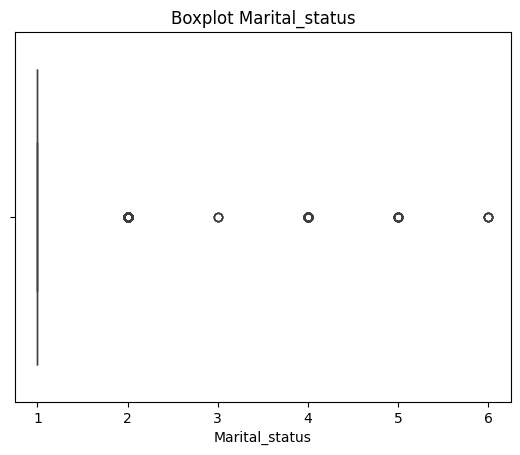

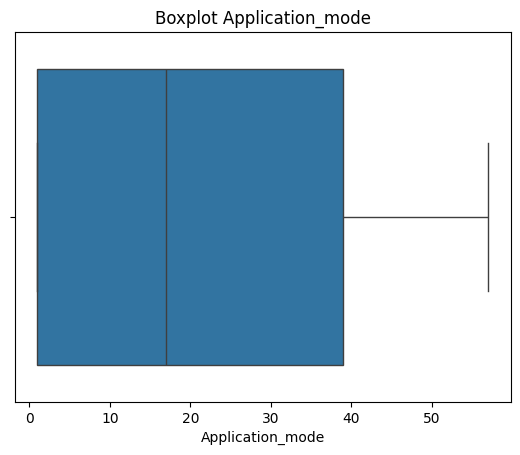

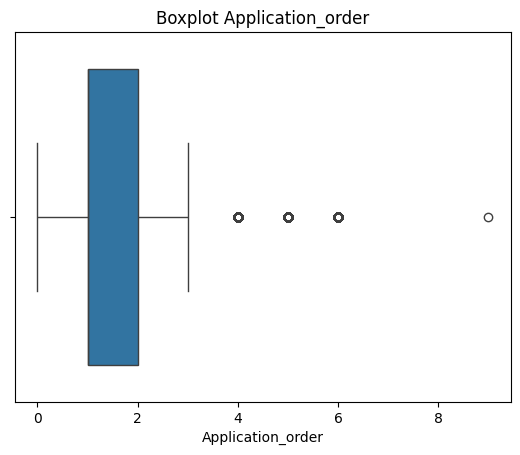

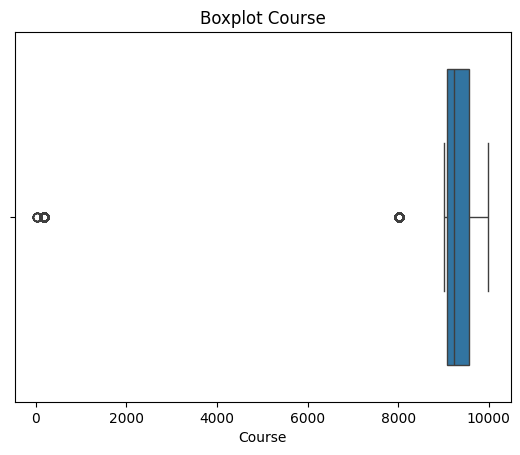

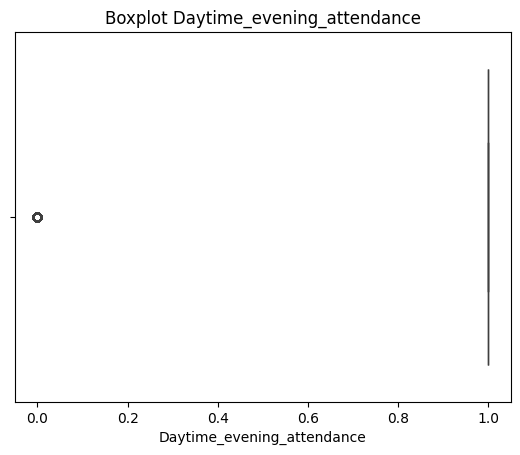

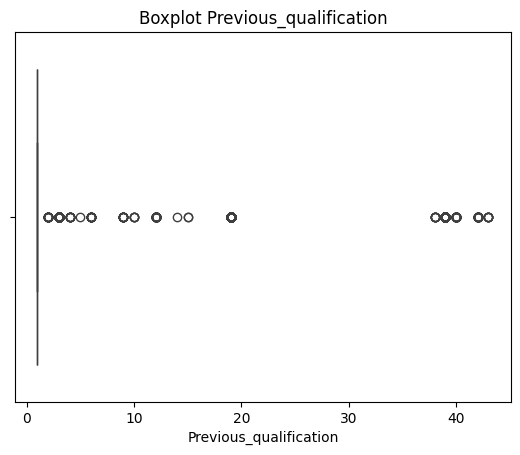

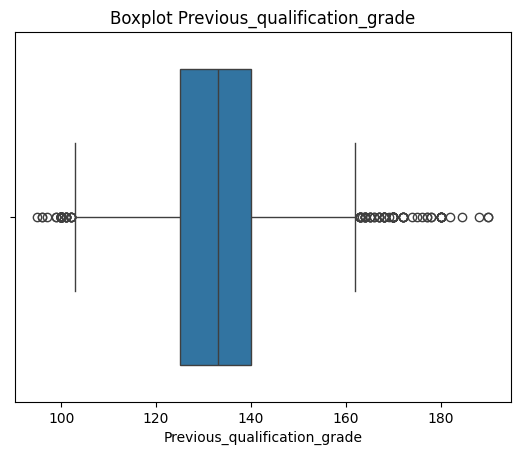

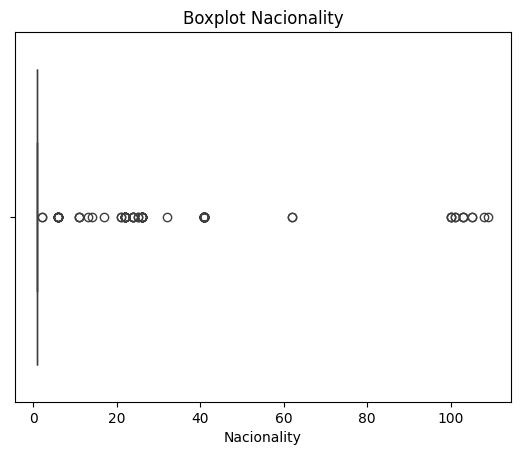

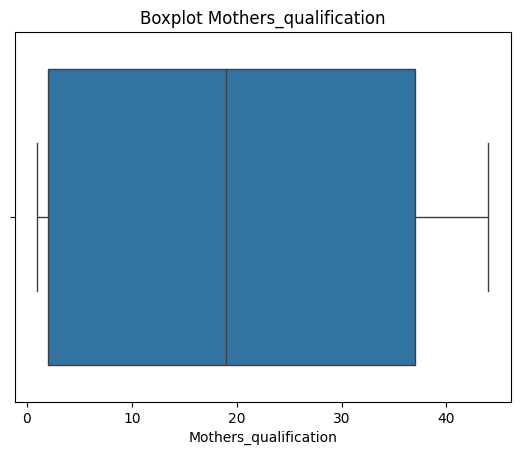

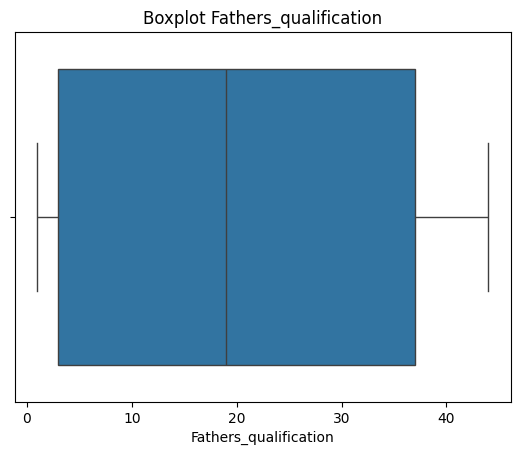

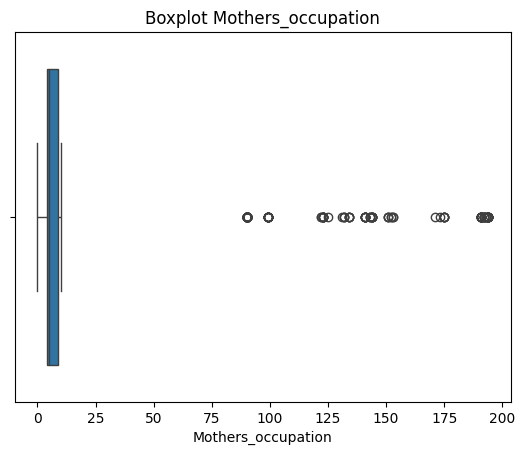

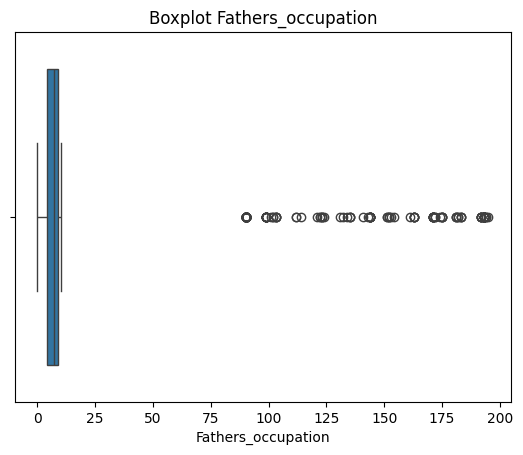

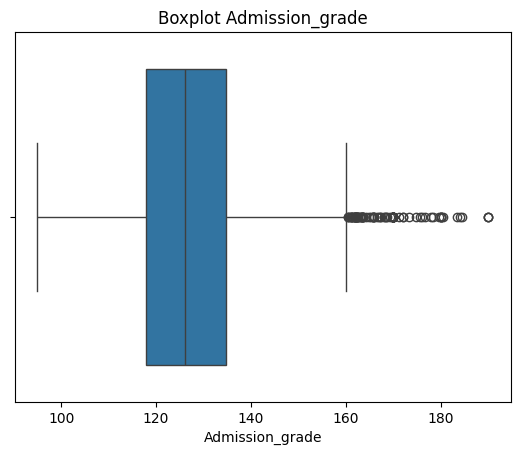

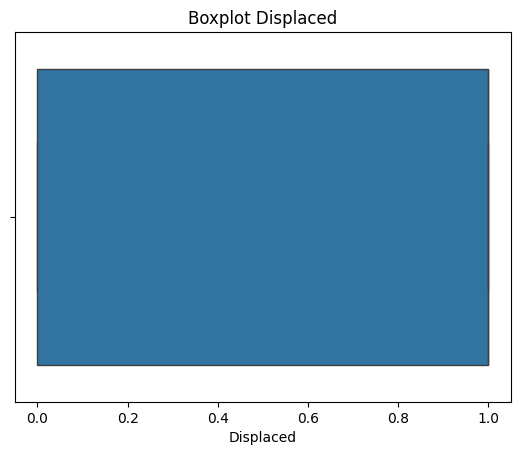

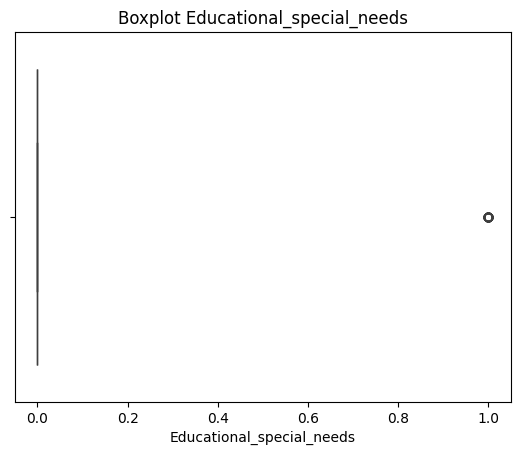

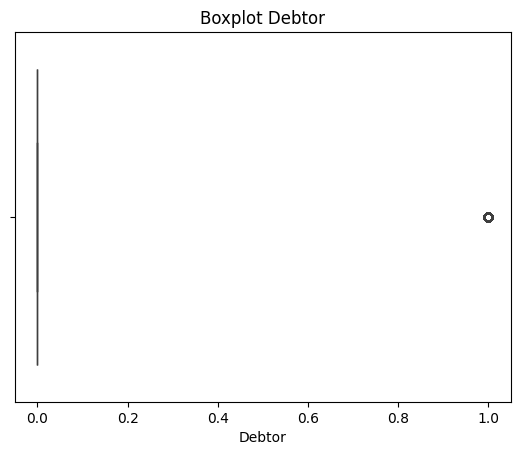

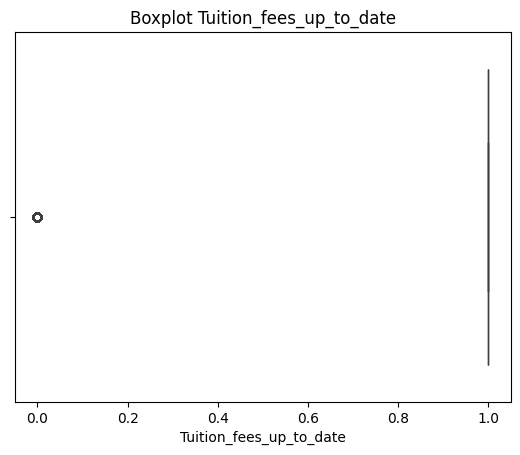

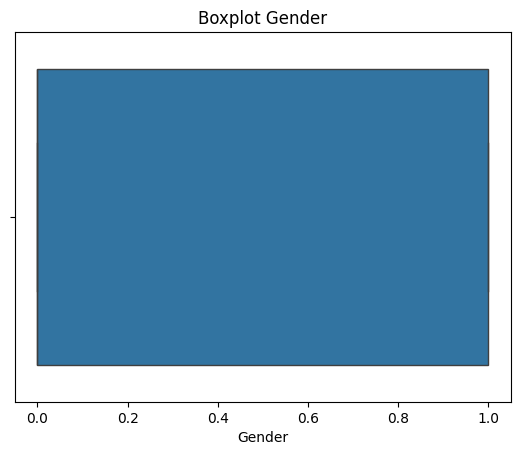

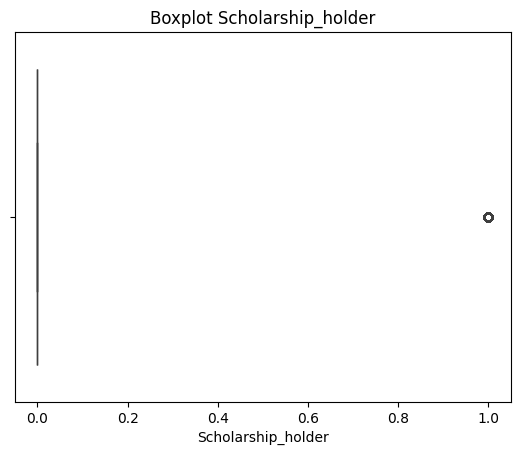

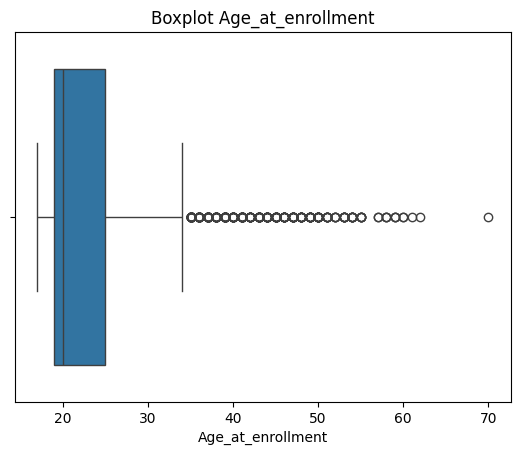

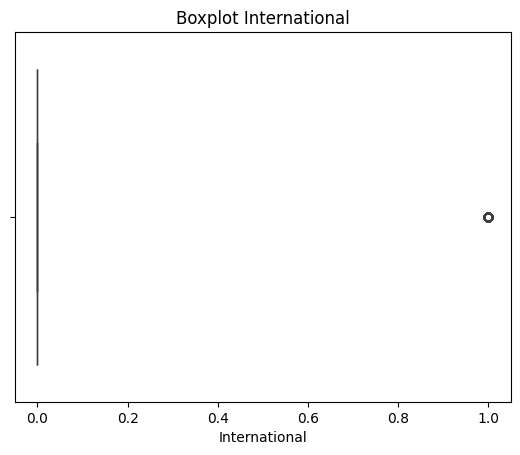

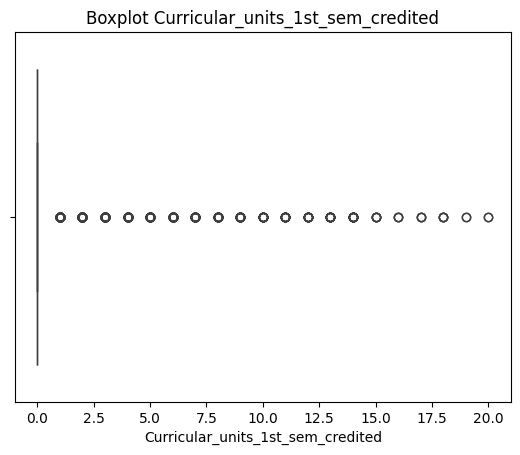

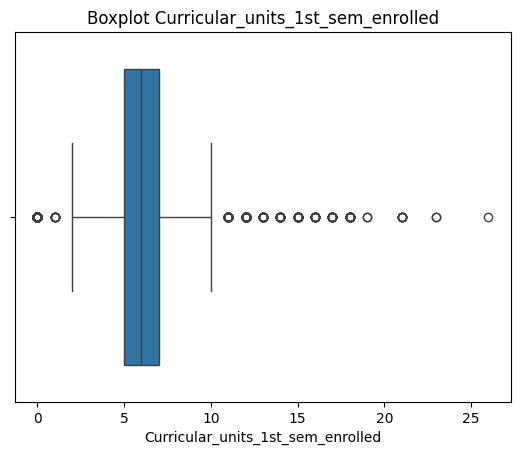

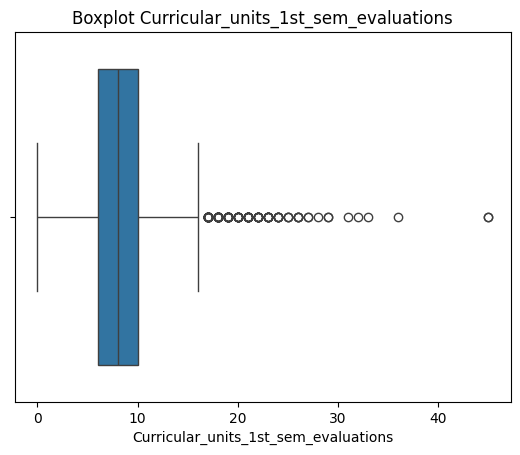

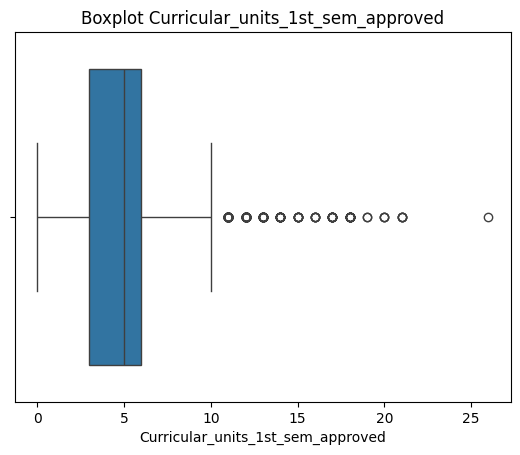

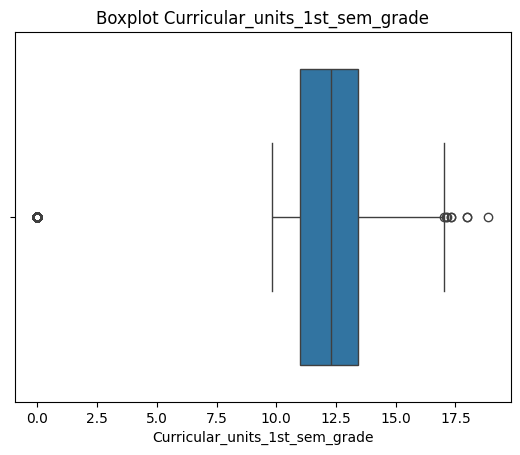

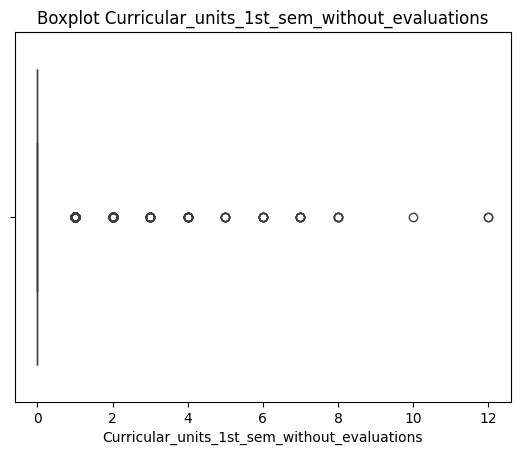

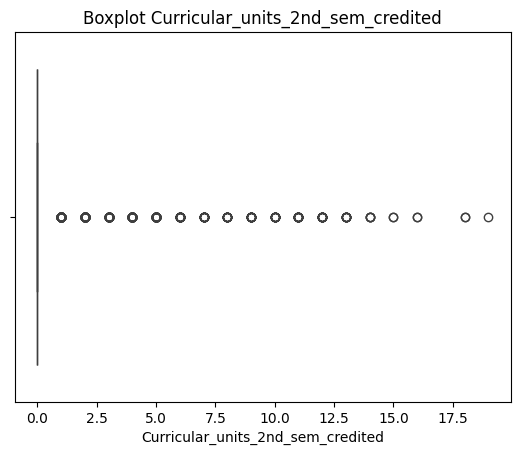

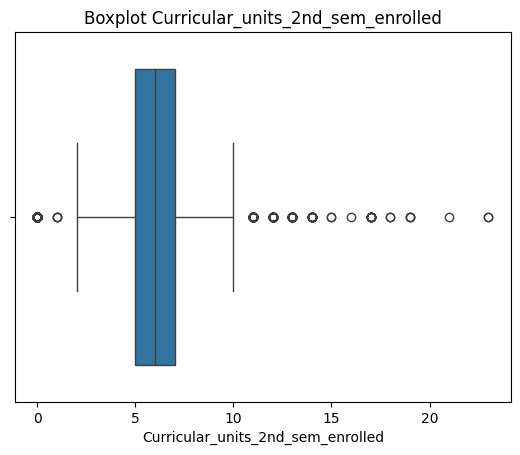

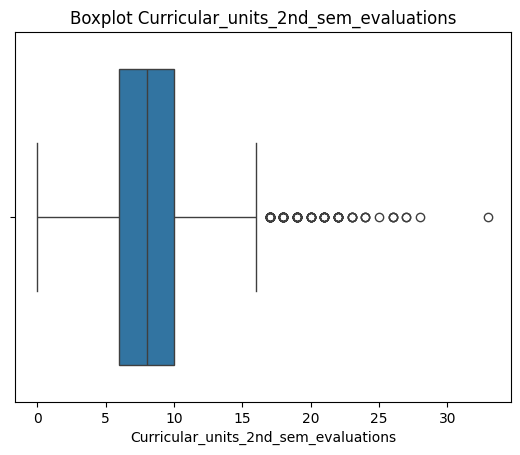

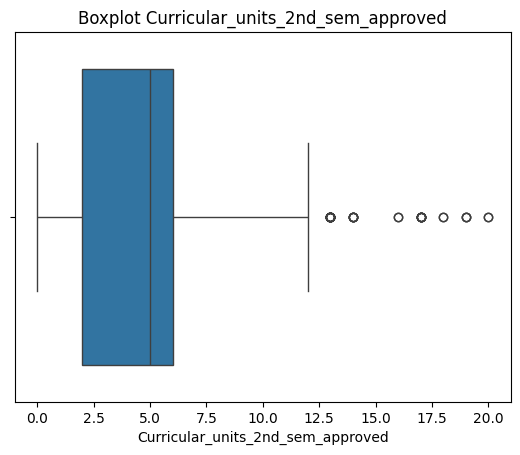

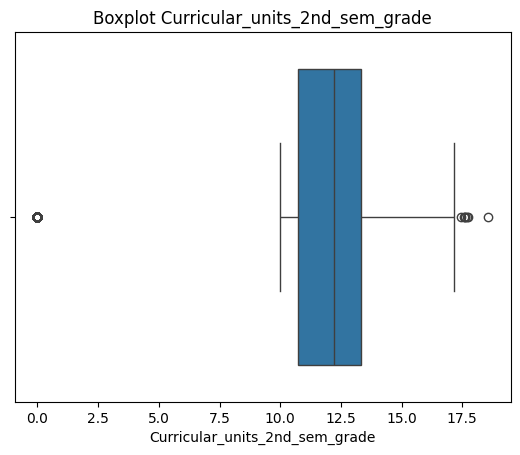

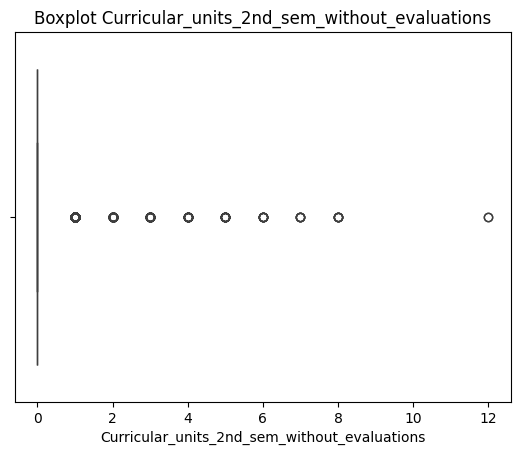

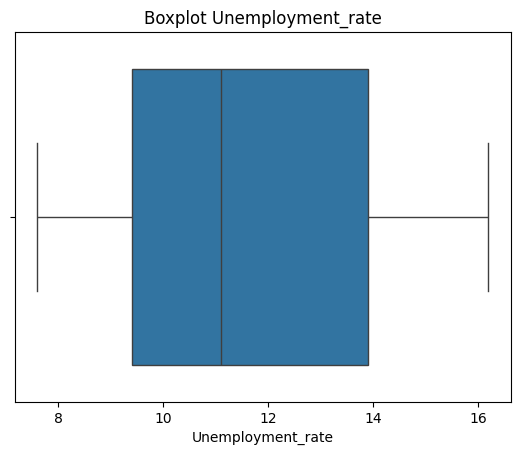

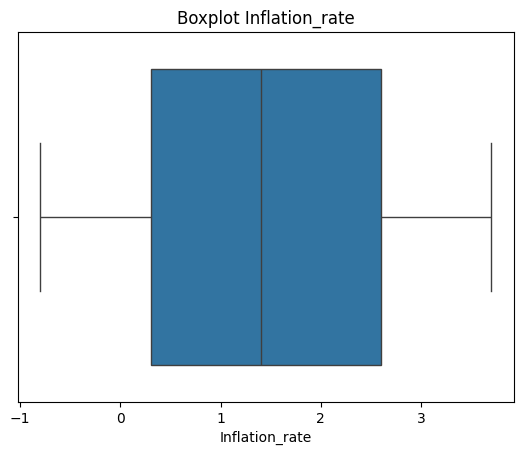

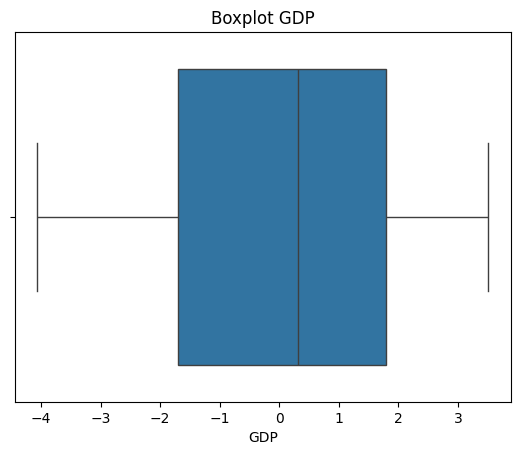

In [7]:
# 7. Visualisasi outlier pada fitur numerik
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot {col}')
    plt.show()


In [8]:
# 8. Hapus outlier pada seluruh fitur numerik dengan metode IQR
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        before = df.shape[0]
        df = df[(df[col] >= lower) & (df[col] <= upper)]
        after = df.shape[0]
        print(f"{col}: removed {before - after} outliers")
    return df

df = remove_outliers_iqr(df, numeric_cols)
print(f"Jumlah data setelah menghapus outlier: {df.shape[0]}")


Marital_status: removed 505 outliers
Application_mode: removed 0 outliers
Application_order: removed 532 outliers
Course: removed 323 outliers
Daytime_evening_attendance: removed 148 outliers
Previous_qualification: removed 421 outliers
Previous_qualification_grade: removed 38 outliers
Nacionality: removed 73 outliers
Mothers_qualification: removed 0 outliers
Fathers_qualification: removed 0 outliers
Mothers_occupation: removed 87 outliers
Fathers_occupation: removed 10 outliers
Admission_grade: removed 47 outliers
Displaced: removed 0 outliers
Educational_special_needs: removed 30 outliers
Debtor: removed 180 outliers
Tuition_fees_up_to_date: removed 110 outliers
Gender: removed 0 outliers
Scholarship_holder: removed 0 outliers
Age_at_enrollment: removed 190 outliers
International: removed 0 outliers
Curricular_units_1st_sem_credited: removed 71 outliers
Curricular_units_1st_sem_enrolled: removed 791 outliers
Curricular_units_1st_sem_evaluations: removed 60 outliers
Curricular_units_1

In [9]:
# 9. Cek ulang data setelah cleaning
print("Jumlah missing value per kolom setelah cleaning:")
print(df.isnull().sum())
print("Tipe data setiap kolom setelah cleaning:")
print(df.dtypes)
print(df.head())

Jumlah missing value per kolom setelah cleaning:
Marital_status                                  0
Application_mode                                0
Application_order                               0
Course                                          0
Daytime_evening_attendance                      0
Previous_qualification                          0
Previous_qualification_grade                    0
Nacionality                                     0
Mothers_qualification                           0
Fathers_qualification                           0
Mothers_occupation                              0
Fathers_occupation                              0
Admission_grade                                 0
Displaced                                       0
Educational_special_needs                       0
Debtor                                          0
Tuition_fees_up_to_date                         0
Gender                                          0
Scholarship_holder                              0
A

In [10]:
# 10. (Opsional) Drop fitur yang tidak informatif jika ada
if low_variance_cols:
    df = df.drop(columns=low_variance_cols)
    print(f"Fitur {low_variance_cols} dihapus dari data.")


In [11]:
# Cek deskripsi statistik
df.describe()

,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,Fathers_qualification,...,Curricular_units_1st_sem_without_evaluations,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP
count,636.0,636.000000,636.000000,636.000000,636.0,636.0,636.000000,636.0,636.000000,636.000000,...,636.0,636.0,636.0,636.000000,636.000000,636.000000,636.0,636.000000,636.000000,636.000000
mean,1.0,7.698113,1.460692,9434.018868,1.0,1.0,131.426887,1.0,17.696541,21.779874,...,0.0,0.0,6.0,7.638365,5.544025,12.841465,0.0,11.774057,1.201572,0.303789
std,0.0,9.708186,0.705454,291.596728,0.0,0.0,11.606091,0.0,15.232499,15.292898,...,0.0,0.0,0.0,1.684961,0.680166,1.205016,0.0,2.521443,1.293642,2.319723
min,1.0,1.000000,1.000000,9003.000000,1.0,1.0,100.000000,1.0,1.000000,1.000000,...,0.0,0.0,6.0,6.000000,4.000000,10.000000,0.0,7.600000,-0.800000,-4.060000
25%,1.0,1.000000,1.000000,9238.000000,1.0,1.0,123.000000,1.0,1.000000,3.000000,...,0.0,0.0,6.0,6.000000,5.000000,12.000000,0.0,9.400000,0.500000,-1.700000
50%,1.0,1.000000,1.000000,9254.000000,1.0,1.0,132.000000,1.0,19.000000,19.000000,...,0.0,0.0,6.0,7.000000,6.000000,12.833333,0.0,11.100000,0.600000,0.790000
75%,1.0,17.000000,2.000000,9773.000000,1.0,1.0,138.000000,1.0,37.000000,37.000000,...,0.0,0.0,6.0,9.000000,6.000000,13.666667,0.0,13.900000,2.600000,1.790000
max,1.0,51.000000,3.000000,9853.000000,1.0,1.0,164.000000,1.0,41.000000,43.000000,...,0.0,0.0,6.0,13.000000,6.000000,16.000000,0.0,16.200000,3.700000,3.510000


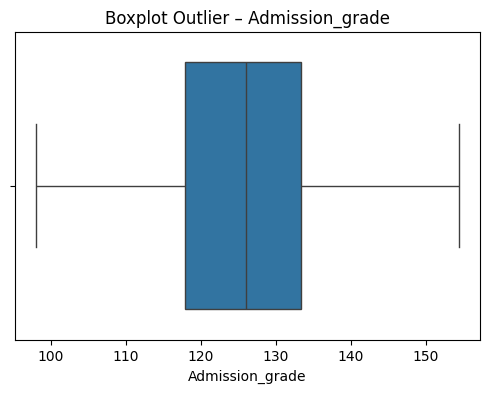

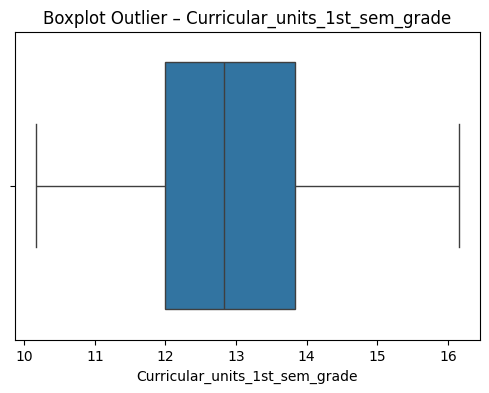

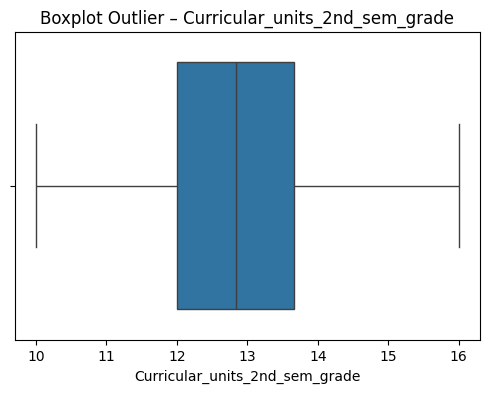

In [12]:
# Cek outlier untuk beberapa kolom penting
important_cols = ["Admission_grade", "Curricular_units_1st_sem_grade", "Curricular_units_2nd_sem_grade"]
for col in important_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x=col)
    plt.title(f"Boxplot Outlier – {col}")
    plt.show()

**3. Exploratory Data Analysis (EDA)**

Tahap ini bertujuan untuk memahami distribusi data dan pola-pola awal yang mungkin berguna untuk modeling. Beberapa analisis dilakukan:
- Distribusi kelas target `Status` untuk mengetahui imbalance.
- Korelasi antar fitur numerik untuk melihat keterkaitan antar variabel.
- Visualisasi distribusi nilai akademik berdasarkan label `Status` untuk menemukan potensi fitur penting.


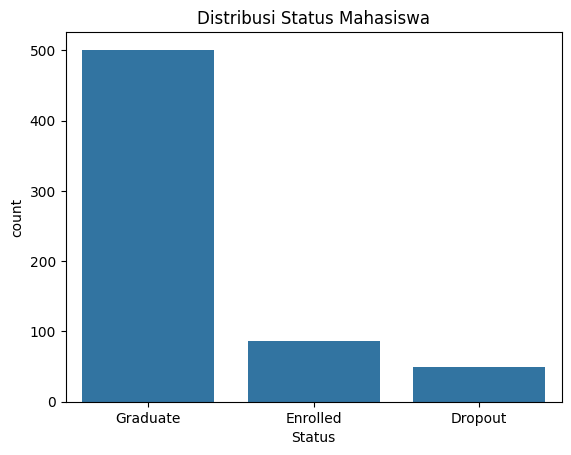

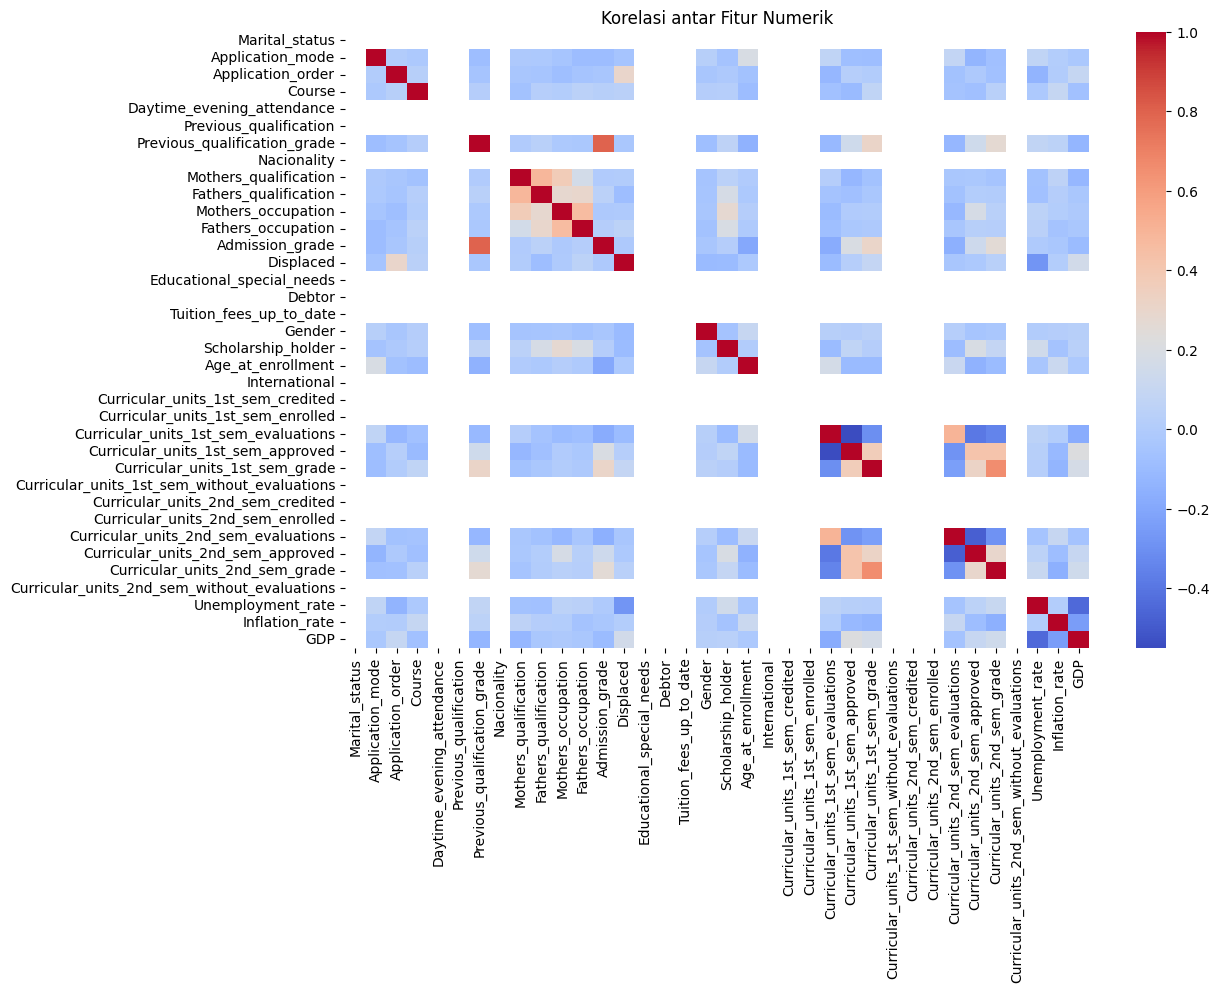

In [13]:
# 11. Exploratory Data Analysis (EDA)
# Distribusi target
sns.countplot(data=df, x="Status")
plt.title("Distribusi Status Mahasiswa")
plt.show()

# Korelasi antar fitur numerik
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Korelasi antar Fitur Numerik")
plt.show()

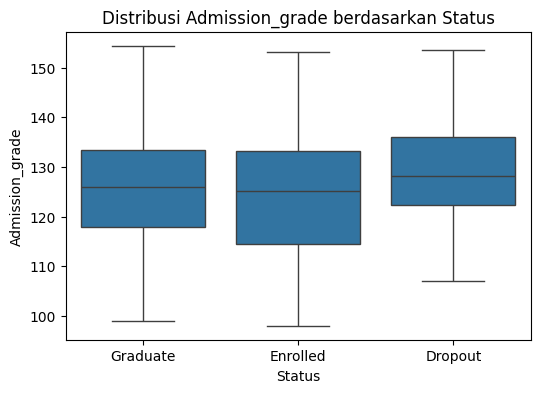

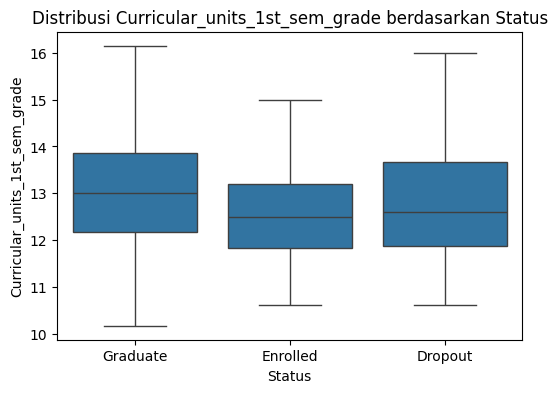

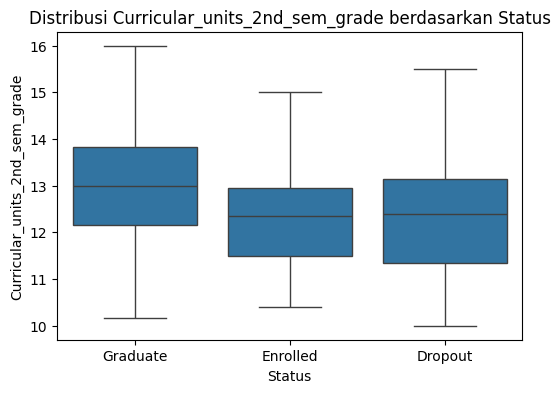

In [14]:
# Boxplot fitur-fitur penting terhadap target
important_cols = ["Admission_grade", "Curricular_units_1st_sem_grade", "Curricular_units_2nd_sem_grade"]
for col in important_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="Status", y=col, data=df)
    plt.title(f"Distribusi {col} berdasarkan Status")
    plt.show()

# Data Preparation / Preprocessing

**4. Preprocessing dan Encoding**

Fitur diklasifikasikan menjadi dua kategori: numerik dan kategorikal. Kita menggunakan pipeline preprocessing untuk membersihkan dan menyiapkan data:
- Fitur numerik: imputasi nilai hilang dengan mean dan normalisasi (StandardScaler).
- Fitur kategorikal: imputasi dengan modus dan encoding menggunakan OneHotEncoder.
Pipeline disatukan dalam `ColumnTransformer` agar proses preprocessing terintegrasi dan replikatif.


In [15]:
categorical_cols = df.select_dtypes(include=["object"]).columns.drop("Status")
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

In [16]:
# Target encoding
df["Target"] = df["Status"].map({"Dropout": 0, "Graduate": 1, "Enrolled": 2})

In [17]:
# Preprocessing pipeline
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("cat", categorical_pipeline, categorical_cols)
])

**5 .Feature Engineering**

Menambahkan fitur baru yang relevan:
- Rasio persetujuan mata kuliah (approved/enrolled) untuk semester 1 dan 2.
- Flag apakah mahasiswa memiliki beasiswa (`has_scholarship`).
Fitur ini dapat meningkatkan prediktivitas model dengan memberikan representasi informasi baru yang lebih kaya.


In [18]:
df["approval_ratio_1st"] = df["Curricular_units_1st_sem_approved"] / df["Curricular_units_1st_sem_enrolled"].replace(0, 1)
df["approval_ratio_2nd"] = df["Curricular_units_2nd_sem_approved"] / df["Curricular_units_2nd_sem_enrolled"].replace(0, 1)

df["has_scholarship"] = df["Scholarship_holder"].apply(lambda x: 1 if x == 1 else 0)

# Update fitur numerik dengan fitur baru
numeric_cols = numeric_cols.tolist() + ["approval_ratio_1st", "approval_ratio_2nd"]

**6. Split Data dan SMOTE**

Dataset dibagi menjadi data latih dan uji menggunakan `train_test_split` dengan stratifikasi agar proporsi kelas tetap seimbang.
Karena terdapat ketidakseimbangan kelas, kita menggunakan SMOTE (Synthetic Minority Over-sampling Technique) untuk menyeimbangkan data latih dengan membuat sampel sintetis dari kelas minoritas.


In [19]:
# Split data latih & uji
X = df.drop(["Status", "Target"], axis=1)
y = df["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Resampling dengan SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_transformed, y_train)


# Modeling

**7. Modeling & Hyperparameter Tuning**

Tiga model digunakan:
- Random Forest
- XGBoost
- CatBoost
Masing-masing model dilakukan hyperparameter tuning menggunakan `GridSearchCV` dengan cross-validation sebanyak 3 fold dan metrik evaluasi `f1_weighted`. Hasil tuning ini memberikan estimator terbaik dari tiap model.


In [20]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf_params = {"n_estimators": [100, 200], "max_depth": [10, 20]}
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring="f1_weighted")
rf_grid.fit(X_resampled, y_resampled)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
xgb_params = {"n_estimators": [100, 200], "max_depth": [5, 10]}
xgb_grid = GridSearchCV(xgb, xgb_params, cv=3, scoring="f1_weighted")
xgb_grid.fit(X_resampled, y_resampled)

# CatBoost
cat = CatBoostClassifier(verbose=0, random_state=42)
cat_params = {"depth": [6, 8], "iterations": [100, 200]}
cat_grid = GridSearchCV(cat, cat_params, cv=3, scoring="f1_weighted")
cat_grid.fit(X_resampled, y_resampled)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000016FED29E6F0>,
             param_grid={'depth': [6, 8], 'iterations': [100, 200]},
             scoring='f1_weighted')

# Evaluation

**8. Evaluation**

Masing-masing model terbaik dievaluasi terhadap data uji menggunakan:
- Classification report (precision, recall, f1-score)
- Confusion matrix
- ROC Curve per kelas (karena target adalah multiclass)
Evaluasi ini memberikan gambaran kinerja model secara menyeluruh pada masing-masing kelas.



Random Forest Evaluation
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.84      0.97      0.90       101
           2       0.78      0.41      0.54        17

    accuracy                           0.82       128
   macro avg       0.54      0.46      0.48       128
weighted avg       0.76      0.82      0.78       128



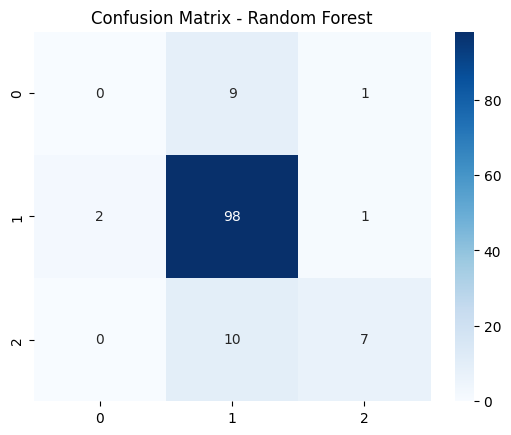

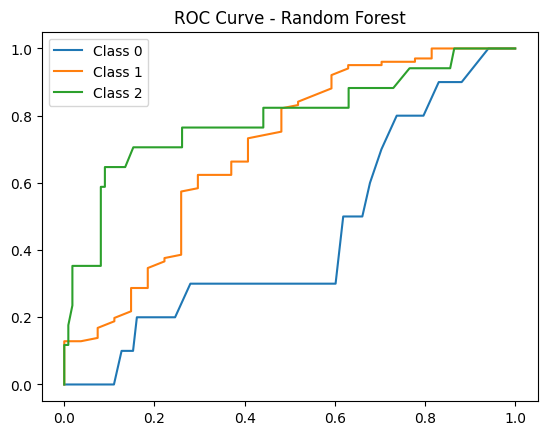


XGBoost Evaluation
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.83      0.90      0.87       101
           2       0.53      0.47      0.50        17

    accuracy                           0.77       128
   macro avg       0.46      0.46      0.46       128
weighted avg       0.73      0.77      0.75       128



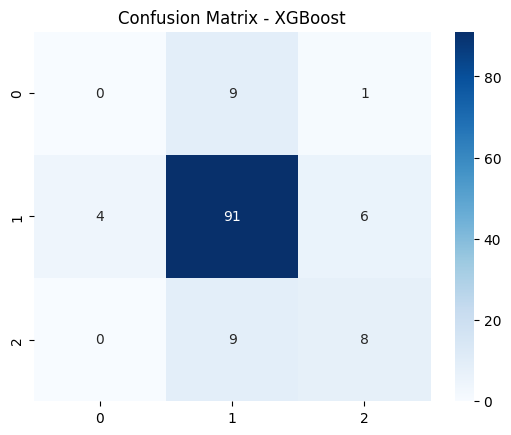

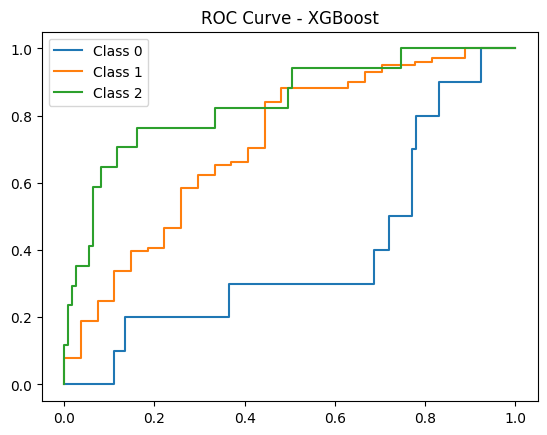


CatBoost Evaluation
              precision    recall  f1-score   support

           0       0.25      0.10      0.14        10
           1       0.84      0.89      0.87       101
           2       0.47      0.47      0.47        17

    accuracy                           0.77       128
   macro avg       0.52      0.49      0.49       128
weighted avg       0.75      0.77      0.76       128



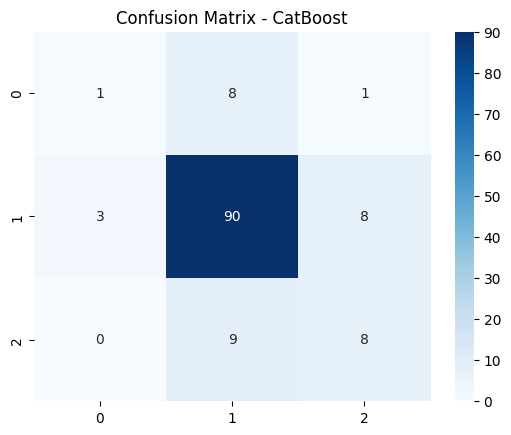

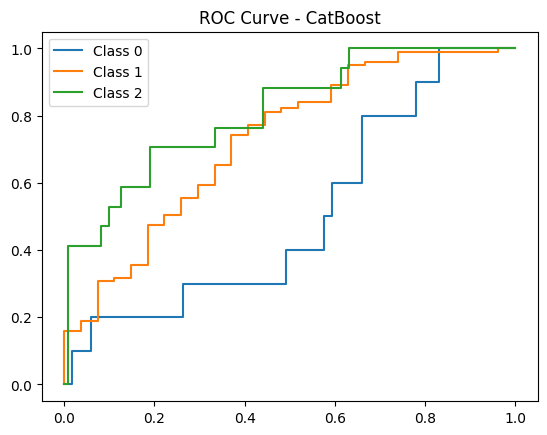

In [21]:
models = {
    "Random Forest": rf_grid.best_estimator_,
    "XGBoost": xgb_grid.best_estimator_,
    "CatBoost": cat_grid.best_estimator_
}

for name, model in models.items():
    print(f"\n{name} Evaluation")
    y_pred = model.predict(X_test_transformed)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # ROC Curve
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_transformed)
        fpr = {}
        tpr = {}
        for i in range(3):
            fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_proba[:, i])
            plt.plot(fpr[i], tpr[i], label=f"Class {i}")
        plt.title(f"ROC Curve - {name}")
        plt.legend()
        plt.show()

**9. SHAP Analysis (Model Interpretability)**

SHAP (SHapley Additive exPlanations) digunakan untuk menginterpretasikan model Random Forest, yang merupakan salah satu model terbaik.
SHAP summary plot digunakan untuk menunjukkan fitur mana yang paling berkontribusi terhadap prediksi model. Ini penting untuk explainability dan validasi model secara etis dan logis.


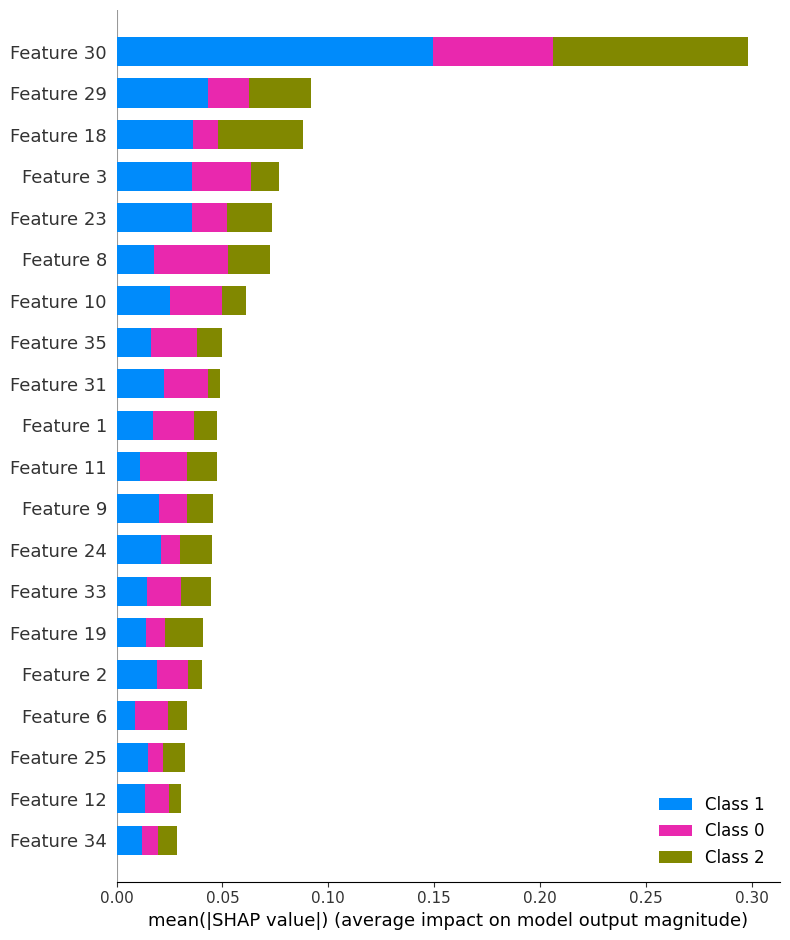

In [22]:
# 9. SHAP Analysis (Random Forest)
explainer = shap.Explainer(models["Random Forest"])
shap_values = explainer(X_test_transformed)
shap.summary_plot(shap_values, features=X_test_transformed)


**10. Save Model**

Model terbaik dari eksperimen dapat disimpan menggunakan `pickle` untuk digunakan kembali pada deployment atau inference di masa depan, tanpa perlu melatih ulang model dari awal.


In [23]:
import joblib
import os

# Buat direktori penyimpanan model
os.makedirs("model", exist_ok=True)

import joblib

# Simpan preprocessor dan model terbaik
best_model = rf_grid.best_estimator_
joblib.dump(preprocessor, "model/preprocessor.pkl")
joblib.dump(best_model, "model/randomforest_model.pkl")
print("Preprocessor dan model berhasil disimpan.")


Preprocessor dan model berhasil disimpan.


In [1]:
import sklearn
print(sklearn.__version__)

1.6.1
